In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import datetime

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

2021-12-05 23:18:26.784432: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# lists possible devices (CPU, GPU)
# used to check if GPU is recognized/exists
tf.config.get_visible_devices()


2021-12-05 23:18:29.499843: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-05 23:18:29.500625: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-05 23:18:29.560300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 23:18:29.560475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8225GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-05 23:18:29.560495: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-05 23:18:29.562129: I tensorflow/stream_executor/platform/d

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

atform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-12-05 23:18:29.563627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2021-12-05 23:18:29.563896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2021-12-05 23:18:29.565621: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.10
2021-12-05 23:18:29.566635: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusparse.so.10
2021-12-05 23:18:29.570317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-05 23:18:29.570462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, 

In [3]:
# preprocessing of the images applied when loading image data set from disk with
# tensorflows flow_from_directory

image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,  # rotate the image 20 degrees
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255,  # Rescale the image by normalzing it.
                                                         shear_range=0.15,
                                                         # Shear means cutting away part of the image (max 20%)
                                                         zoom_range=0.15,  # Zoom in by 15% max
                                                         horizontal_flip=True,  # Allow horizontal flipping
                                                         fill_mode='nearest'
                                                         # Fill in missing pixels with the nearest filled value
                                                         )

In [30]:
# path to the image data set

#train_data_path = './drive/MyDrive/Bachelor/data_balanced/train' #google colab
#test_data_path = './drive/MyDrive/Bachelor/data_balanced/test' #google colab
#validation_data_path = './drive/MyDrive/Bachelor/data_balanced/validation' #google colab
train_data_path = './data/data_heavily_reduced/data_balanced/train'  #local notebook
test_data_path = './data/data_heavily_reduced/data_balanced/test'  #local notebook
validation_data_path = './data/data_heavily_reduced/data_balanced/val'  #local notebook


In [33]:
# generate training set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {train} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

train_image_gen = image_gen.flow_from_directory(train_data_path,
                                                target_size=(224, 224),
                                                class_mode='binary')

Found 7999 images belonging to 2 classes.


In [34]:
# generate test set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {test} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

test_image_gen = image_gen.flow_from_directory(test_data_path,
                                               target_size=(224, 224),
                                               class_mode='binary')

Found 1001 images belonging to 2 classes.


In [35]:
# generate validation set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {validation} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

valid_set = image_gen.flow_from_directory(validation_data_path,
                                          target_size=(224, 224),
                                          class_mode='binary')

Found 999 images belonging to 2 classes.


In [17]:
# saves the model and its weights as a json file in the folder saved_models

def save_model(model, model_name):
    my_model = model.to_json()
    with open(f'./saved_models/{model_name}.json', "w") as file:
        file.write(my_model)
    # serialize weights to HDF5
    model.save_weights(f'./saved_models/{model_name}_weights.h5')

In [18]:
#TODO: load model no compiling ?

def load_model(model_path, weight_path):
    # load json and create model
    file = open(model_path, 'r')
    model_json = file.read()
    file.close()
    loaded_model = keras.models.model_from_json(model_json)
    # load weights
    loaded_model.load_weights(weight_path)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
    loaded_model.compile(loss="binary_crossentropy", optimizer=optimizer,
                         metrics=['accuracy', 'Recall', 'Precision', 'AUC'])
    return loaded_model

In [19]:
input = tf.keras.Input(shape=(224, 224, 3))
vgg16 = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                          include_top=False,
                                          input_tensor=input)


flat = keras.layers.Flatten(name='flatten')(vgg16.output)
dense_1 = keras.layers.Dense(1000)(flat)
dropout = keras.layers.Dropout(0.25)(dense_1)
batch = keras.layers.BatchNormalization()(dropout)
output = keras.layers.Dense(1, activation='sigmoid')(batch)

# bind all
model = tf.keras.Model(vgg16.input, output)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [21]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

# freeze layers
for layer in vgg16.layers:
    layer.trainable = False

history = model.fit(train_image_gen,
                    validation_data=test_image_gen,
                    epochs=5,
                    callbacks=[])

# un freeze
for layer in vgg16.layers:
    layer.trainable = True

custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)
# tesorboard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', 'Recall', 'Precision', 'AUC'])
history = model.fit(train_image_gen,
                    validation_data=test_image_gen,
                    epochs=100,
                    callbacks=[custom_early_stopping, tensorboard_callback])


Epoch 1/5


2021-12-05 23:22:01.676514: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-05 23:22:02.557718: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-05 23:22:02.580262: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-05 23:22:03.117499: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-05 23:22:09.925079: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with free

1509/1509 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8227 - recall: 0.7958 - precision: 0.5064 - auc: 0.8907

2021-12-05 23:31:48.100463: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1509/1509 [==============================] - 591s 384ms/step - loss: 0.4084 - accuracy: 0.8228 - recall: 0.7958 - precision: 0.5065 - auc: 0.8908 - val_loss: 0.1015 - val_accuracy: 0.9594 - val_recall: 0.9301 - val_precision: 0.8418 - val_auc: 0.9909
Epoch 2/5
1509/1509 [==============================] - 569s 377ms/step - loss: 0.1062 - accuracy: 0.9604 - recall: 0.8858 - precision: 0.8768 - auc: 0.9859 - val_loss: 0.4404 - val_accuracy: 0.9304 - val_recall: 0.5804 - val_precision: 1.0000 - val_auc: 0.8961
Epoch 3/5
1509/1509 [==============================] - 569s 377ms/step - loss: 0.0552 - accuracy: 0.9810 - recall: 0.9385 - precision: 0.9465 - auc: 0.9953 - val_loss: 0.3431 - val_accuracy: 0.8777 - val_recall: 0.9990 - val_precision: 0.5757 - val_auc: 0.9952
Epoch 4/5
1509/1509 [==============================] - 569s 377ms/step - loss: 0.0354 - accuracy: 0.9874 - recall: 0.9625 - precision: 0.9621 - auc: 0.9981 - val_loss: 0.1345 - val_accuracy: 0.9508 - val_recall: 0.9990 - val_pr

2021-12-06 00:09:47.476327: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-06 00:09:47.476375: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-06 00:09:47.476898: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2021-12-06 00:09:47.487203: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2021-12-06 00:09:47.588730: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2021-12-06 00:09:47.588930: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
   1/1509 [..............................] - ETA: 37:15 - loss: 0.0019 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000

2021-12-06 00:09:49.402077: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-06 00:09:49.402097: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-06 00:09:49.402494: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


   2/1509 [..............................] - ETA: 10:07 - loss: 0.0023 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000

2021-12-06 00:09:49.780016: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-06 00:09:49.789294: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-06 00:09:49.791228: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-06 00:09:49.796040: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_06_00_09_49
2021-12-06 00:09:49.796819: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_12_06_00_09_49/pop-os.trace.json.gz
2021-12-06 00:09:49.811683: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_06_00_09_49
2021-12-06 00:09:49.814296: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped

1509/1509 [==============================] - 575s 380ms/step - loss: 0.0184 - accuracy: 0.9938 - recall: 0.9811 - precision: 0.9819 - auc: 0.9989 - val_loss: 0.0197 - val_accuracy: 0.9932 - val_recall: 0.9640 - val_precision: 0.9948 - val_auc: 0.9983
Epoch 2/100
1509/1509 [==============================] - 572s 379ms/step - loss: 0.0183 - accuracy: 0.9942 - recall: 0.9811 - precision: 0.9842 - auc: 0.9983 - val_loss: 0.0206 - val_accuracy: 0.9920 - val_recall: 0.9990 - val_precision: 0.9551 - val_auc: 1.0000
Epoch 3/100
1509/1509 [==============================] - 573s 380ms/step - loss: 0.0156 - accuracy: 0.9948 - recall: 0.9836 - precision: 0.9849 - auc: 0.9992 - val_loss: 0.0301 - val_accuracy: 0.9919 - val_recall: 0.9990 - val_precision: 0.9542 - val_auc: 0.9999
Epoch 4/100
1509/1509 [==============================] - 573s 380ms/step - loss: 0.0106 - accuracy: 0.9967 - recall: 0.9884 - precision: 0.9916 - auc: 0.9995 - val_loss: 0.0166 - val_accuracy: 0.9940 - val_recall: 0.9940 - 

In [21]:
history

In [22]:
save_model(model, 'vgg16_full_data_v2')

In [28]:
# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, accuracy, recall, precision, auc = model.evaluate(valid_set)

189/189 [==============================] - 53s 279ms/step - loss: 5.4609e-04 - accuracy: 0.9998 - recall: 1.0000 - precision: 0.9990 - auc: 1.0000


In [29]:
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")

loss: 0.0005460858228616416, 
accuracy: 0.9998342394828796, 
recall: 1.0, 
precision: 0.9990000128746033, 
auc: 0.9999999403953552, 
F1: 0.9994997563186812


In [31]:
input = tf.keras.Input(shape=(224, 224, 3))
vgg16 = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                          include_top=False,
                                          input_tensor=input)


flat = keras.layers.Flatten(name='flatten')(vgg16.output)
dense_1 = keras.layers.Dense(1000)(flat)
dropout = keras.layers.Dropout(0.25)(dense_1)
batch = keras.layers.BatchNormalization()(dropout)
output = keras.layers.Dense(1, activation='sigmoid')(batch)

# bind all
model_reduced = tf.keras.Model(vgg16.input, output)

In [36]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

model_reduced.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

# freeze layers
for layer in vgg16.layers:
    layer.trainable = False

history = model_reduced.fit(train_image_gen,
                    validation_data=test_image_gen,
                    epochs=5,
                    callbacks=[])

# un freeze
for layer in vgg16.layers:
    layer.trainable = True

custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)
# tesorboard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

model_reduced.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', 'Recall', 'Precision', 'AUC'])
history = model_reduced.fit(train_image_gen,
                    validation_data=test_image_gen,
                    epochs=100,
                    callbacks=[custom_early_stopping, tensorboard_callback])


Epoch 1/5
127/250 [==============>...............] - ETA: 32s - loss: 0.2277 - accuracy: 0.9135 - recall: 0.8527 - precision: 0.9724 - auc: 0.9876

2021-12-06 08:34:41.300185: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-06 08:34:41.300240: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-06 08:34:42.272324: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


250/250 [==============================] - 84s 332ms/step - loss: 0.1788 - accuracy: 0.9331 - recall: 0.8949 - precision: 0.9696 - auc: 0.9893 - val_loss: 0.0813 - val_accuracy: 0.9630 - val_recall: 0.9461 - val_precision: 0.9793 - val_auc: 0.9964
Epoch 2/5
250/250 [==============================] - 73s 292ms/step - loss: 0.0880 - accuracy: 0.9654 - recall: 0.9646 - precision: 0.9657 - auc: 0.9949 - val_loss: 0.0734 - val_accuracy: 0.9750 - val_recall: 0.9780 - val_precision: 0.9722 - val_auc: 0.9962
Epoch 3/5
250/250 [==============================] - 73s 293ms/step - loss: 0.0799 - accuracy: 0.9691 - recall: 0.9701 - precision: 0.9669 - auc: 0.9953 - val_loss: 0.0617 - val_accuracy: 0.9800 - val_recall: 0.9741 - val_precision: 0.9859 - val_auc: 0.9977
Epoch 4/5
250/250 [==============================] - 71s 285ms/step - loss: 0.0915 - accuracy: 0.9654 - recall: 0.9637 - precision: 0.9677 - auc: 0.9941 - val_loss: 0.0552 - val_accuracy: 0.9800 - val_recall: 0.9920 - val_precision: 0.9

2021-12-06 08:40:18.372534: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-06 08:40:18.372561: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-06 08:40:18.372626: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-12-06 08:40:18.372646: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
  1/250 [..............................] - ETA: 6:20 - loss: 0.0554 - accuracy: 0.9688 - recall: 0.9412 - precision: 1.0000 - auc: 1.0000

2021-12-06 08:40:20.218541: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-06 08:40:20.218568: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-06 08:40:20.218623: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  2/250 [..............................] - ETA: 1:38 - loss: 0.3559 - accuracy: 0.9141 - recall: 0.8706 - precision: 0.9444 - auc: 0.9319

2021-12-06 08:40:20.900934: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-06 08:40:20.905848: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-06 08:40:20.907164: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-06 08:40:20.908696: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_06_08_40_20
2021-12-06 08:40:20.909490: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_12_06_08_40_20/pop-os.trace.json.gz
2021-12-06 08:40:20.927781: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_06_08_40_20
2021-12-06 08:40:20.931204: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped

 38/250 [===>..........................] - ETA: 1:10 - loss: 0.5917 - accuracy: 0.8208 - recall: 0.7536 - precision: 0.8663 - auc: 0.8840

2021-12-06 08:40:33.805706: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-06 08:40:35.391137: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


250/250 [==============================] - 96s 380ms/step - loss: 0.4144 - accuracy: 0.8573 - recall: 0.8171 - precision: 0.8865 - auc: 0.9242 - val_loss: 0.3328 - val_accuracy: 0.8961 - val_recall: 1.0000 - val_precision: 0.8281 - val_auc: 0.9849
Epoch 2/100
250/250 [==============================] - 88s 351ms/step - loss: 0.1873 - accuracy: 0.9349 - recall: 0.9384 - precision: 0.9315 - auc: 0.9800 - val_loss: 1.9372 - val_accuracy: 0.5245 - val_recall: 1.0000 - val_precision: 0.5128 - val_auc: 0.8910
Epoch 3/100
250/250 [==============================] - 88s 351ms/step - loss: 0.1277 - accuracy: 0.9567 - recall: 0.9630 - precision: 0.9513 - auc: 0.9891 - val_loss: 0.0957 - val_accuracy: 0.9680 - val_recall: 0.9980 - val_precision: 0.9416 - val_auc: 0.9948
Epoch 4/100
250/250 [==============================] - 88s 352ms/step - loss: 0.1152 - accuracy: 0.9575 - recall: 0.9628 - precision: 0.9519 - auc: 0.9909 - val_loss: 0.0685 - val_accuracy: 0.9750 - val_recall: 0.9960 - val_precisio

In [37]:
save_model(model, 'vgg16_heavily_reduced_data_v2.1')

In [38]:
# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, accuracy, recall, precision, auc = model.evaluate(valid_set)

32/32 [==============================] - 14s 443ms/step - loss: 0.0045 - accuracy: 0.9990 - recall: 0.9980 - precision: 1.0000 - auc: 1.0000


In [39]:
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")

loss: 0.004525561351329088, 
accuracy: 0.9989989995956421, 
recall: 0.9979959726333618, 
precision: 1.0, 
auc: 1.0, 
F1: 0.998996981278197


In [40]:
from tensorflow.keras.models import Model
import cv2


class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            print(self.model.layers)
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [53]:
image = cv2.imread('data/data_predictions/MyRecord2021-11-19T125431028-from_00_49_00.00.mp4-img-44016.jpg')
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image)
i = np.argmax(preds[0])

In [54]:
# for idx in range(len(model.layers)):
#     print(model.get_layer(index=idx).name)

In [55]:
icam = GradCAM(model, i, 'block5_conv3')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('data/data_predictions/MyRecord2021-11-19T125431028-from_00_49_00.00.mp4-img-44016.jpg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(224, 224) (224, 224, 3)


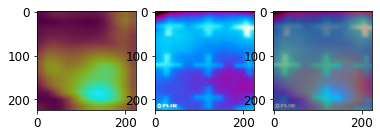

In [56]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)